# Determining constants for the Leishman-Beddoes dynamic stall model

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy import sin, cos, exp, pi, log, sqrt
import pandas as pd
import seaborn

In [20]:
# Function for loading data
def load():
    alpha = []
    cl = []
    cd = []
    with open("data/NACA0021.dat") as f:
        for line in f.readlines():
            if line.strip()[:2] == "//":
                pass
            else:
                line = line.replace("(", "")
                line = line.replace(")", "")
                line = line.split()
                alpha.append(float(line[0]))
                cl.append(float(line[1]))
                cd.append(float(line[2]))
    df = pd.DataFrame()
    df["alpha_deg"] = np.asarray(alpha)
    df["alpha_rad"] = df.alpha_deg/180.0*np.pi
    df["cl"] = np.asarray(cl)
    df["cd"] = np.asarray(cd)
    df["cn"] = df.cl*np.cos(df.alpha_rad) - df.cd*np.sin(df.alpha_rad)
    df["ct"] = df.cl*np.sin(df.alpha_rad) - df.cd*np.cos(df.alpha_rad)
    return df

In [21]:
# Least squares fitting for finding s1 and s2
# Kept as close to the C++ code as possible to return back

def calc_s1_s2(df, alpha1, cn_alpha):
    sumY = 0.0
    sumXYLnY = 0.0
    sumXY = 0.0
    sumYLnY = 0.0
    sumX2Y = 0.0
    alphaLowerLimit = 0.0
    alphaUpperLimit = alpha1

    #Translational stuff
    alphaDegList = df.alpha_deg.values
    clList = df.cl.values
    cdList = df.cd.values
    CNAlpha = cn_alpha
    mag = abs
    
    # Calculate S1
    for i in range(len(alphaDegList)):
        alphaRad = alphaDegList[i]/180.0*pi
        cn = clList[i]*cos(alphaRad) - cdList[i]*sin(alphaRad)
        if (alphaRad > alphaLowerLimit and alphaRad < alphaUpperLimit):
            f = pow((sqrt(abs(cn)/CNAlpha/abs(alphaRad))*2.0 - 1.0), 2)
            x = abs(alphaRad) - alpha1
            y = (f - 1)/(-0.4)
            if (f > 0 and f < 1 and y > 0):
                sumY += y
                sumXYLnY += x*y*log(y)
                sumXY += x*y
                sumYLnY += y*log(y)
                sumX2Y += x*x*y

    b = (sumY*sumXYLnY - sumXY*sumYLnY)/(sumY*sumX2Y - sumXY*sumXY)
    S1 = 1.0/b

    # Calculate S2
    sumY = 0.0
    sumXYLnY = 0.0
    sumXY = 0.0
    sumYLnY = 0.0
    sumX2Y = 0.0
    alphaLowerLimit = alpha1 - 1e-3
    alphaUpperLimit = pi/6.0
    for i in range(len(alphaDegList)):
        alphaRad = alphaDegList[i]/180.0*pi
        cn = clList[i]*cos(alphaRad) - cdList[i]*sin(alphaRad)
        if (alphaRad > alphaLowerLimit and alphaRad < alphaUpperLimit):
            f = pow((sqrt(mag(cn)/CNAlpha/mag(alphaRad))*2.0 - 1.0), 2)
            x = alpha1 - abs(alphaRad);
            y = (f - 0.02)/0.58;
            if (f > 0 and f < 1 and y > 0):
                sumY += y
                sumXYLnY += x*y*log(y)
                sumXY += x*y
                sumYLnY += y*log(y)
                sumX2Y += x*x*y
    b = (sumY*sumXYLnY - sumXY*sumYLnY)/(sumY*sumX2Y - sumXY*sumXY)
    S2 = 1.0/b
    
    return S1, S2

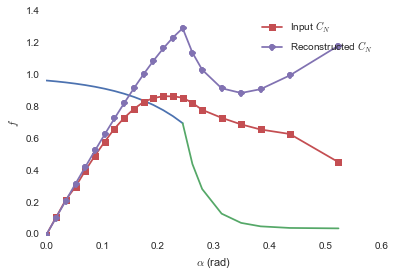

In [22]:
df = load()

# Calculate normal force slope
cn_alpha = (df.cn[df.alpha_deg==2.0].iloc[0] - df.cn[df.alpha_deg==0.0].iloc[0])/(2.0/180.0*np.pi)

# Find static stall angle
d_cd_d_alpha = np.diff(df.cd)/np.diff(df.alpha_deg)
n = np.where(d_cd_d_alpha > 0.02)[0]
alpha_ss = df.alpha_deg[n]
alpha_ss = alpha_ss[alpha_ss > 0].iloc[0]

# Find critical normal force coefficient
fcrit = 0.7
alpha1 = alpha_ss/180.0*np.pi
cn1 = cn_alpha*alpha1*((1 + np.sqrt(fcrit))/2.0)**2

# Put in some values for s1 and s2 (from turbinesFoam)
s1 = 0.109504058813
s2 = 0.0355536753234
s1, s2 = calc_s1_s2(df, alpha1, cn_alpha)

ind = np.logical_and(df.alpha_deg >=0, df.alpha_deg <= 30)
alpha = df.alpha_rad[ind]
alpha_low = alpha[alpha <= alpha1]
alpha_high = alpha[alpha >= alpha1]
f_low = 1.0 - 0.3*np.exp((alpha_low - alpha1)/s1)
f_high = 0.04 + 0.66*np.exp((alpha1 - alpha_high)/s2)

# Reconstruct normal force from f
cn_low = cn_alpha*alpha_low*((1 + np.sqrt(f_low))/2)**2
cn_high = cn_alpha*alpha_high*((1 + np.sqrt(f_high))/2)**2
cn = np.hstack((cn_low, cn_high[1:]))

plt.plot(alpha_low, f_low)
plt.plot(alpha_high, f_high)
plt.plot(alpha, df.cn[ind], "-s", label=r"Input $C_N$")
plt.plot(alpha, cn, "-o", label=r"Reconstructed $C_N$")
plt.xlabel(r"$\alpha$ (rad)")
plt.ylabel("$f$")
plt.legend(loc="best")
plt.savefig("figures/f.pdf")
plt.show()